In [ ]:
!pip install --quiet neo4j langchain-community langchain-core langchain-openai langchain-text-splitters tiktoken wikipedia

In [1]:
import asyncio
import getpass
import os
from datetime import datetime
from hashlib import md5
from typing import Dict, List

import pandas as pd
import seaborn as sns
import tiktoken
from langchain_community.graphs import Neo4jGraph
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_text_splitters import TokenTextSplitter
from pydantic import BaseModel, Field

/Users/tomazbratanic/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Graph construction

Use this notebook to construct a graph

# Environment Setup
You need to setup a Neo4j to follow along with the examples in this blog post. The easiest way is to start a free instance on Neo4j Aura, which offers cloud instances of Neo4j database. Alternatively, you can also setup a local instance of the Neo4j database by downloading the Neo4j Desktop application and creating a local database instance.

The following code will instantiate a LangChain wrapper to connect to Neo4j Database.

In [2]:
os.environ["NEO4J_URI"] = "bolt://localhost:7687"
os.environ["NEO4J_USERNAME"] = "neo4j"
os.environ["NEO4J_PASSWORD"] = "password"

graph = Neo4jGraph(refresh_schema=False)

graph.query("CREATE CONSTRAINT IF NOT EXISTS FOR (c:Chunk) REQUIRE c.id IS UNIQUE")
graph.query("CREATE CONSTRAINT IF NOT EXISTS FOR (c:AtomicFact) REQUIRE c.id IS UNIQUE")
graph.query("CREATE CONSTRAINT IF NOT EXISTS FOR (c:KeyElement) REQUIRE c.id IS UNIQUE")
graph.query("CREATE CONSTRAINT IF NOT EXISTS FOR (d:Document) REQUIRE d.id IS UNIQUE")

[]

Additionally, we have also added constraints for the node types we will be using. The constraints ensure faster import and retrieval performance.

You will require an OpenAI api key that you pass in the following code:

In [3]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

OpenAI API Key: ········


We will be using the Joan of Arc Wikipedia page in this example. We will use LangChain built-in utility to retrieve the text.

In [4]:
wikipedia = WikipediaQueryRun(
    api_wrapper=WikipediaAPIWrapper(doc_content_chars_max=10000)
)
text = wikipedia.run("Joan of Arc")


As mentioned before, the GraphReader agent expects knowledge graph that contains chunks, related atomic facts, and key elements.

![image](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*ZU6kh8gAMkQjUiUTgaNFPQ.png)

First, the document is split into chunks. In the paper they maintained paragraph structure while chunking. However, that is hard to do in a generic way. Therefore, we will use naive chunking here.

Next, each chunk is processed by the LLM to identify atomic facts, which are the smallest, indivisible units of information that capture core details. For instance, from the sentence “The CEO of Neo4j, which is in Sweden, is Emil Eifrem” an atomic fact could be broken down into something like “The CEO of Neo4j is Emil Eifrem.” and “Neo4j is in Sweden.” Each atomic fact is focused on one clear, standalone piece of information.

From these atomic facts, key elements are identified. For the first fact, “The CEO of Neo4j is Emil Eifrem,” the key elements would be “CEO,” “Neo4j,” and “Emil Eifrem.” For the second fact, “Neo4j is in Sweden,” the key elements would be “Neo4j” and “Sweden.” These key elements are the essential nouns and proper names that capture the core meaning of each atomic fact.

The prompt used to extract the graph are provided in the appendix of the paper.

![image](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*U2K7VoON6thak0TeQq2svw.png)

The authors used prompt-based extraction, where you instruct the LLM what it should output and then implement a function that parses the information in a structured manner. My preference for extracting structured information is to use the with_structured_output method in LangChain, which utilizes the tools feature to extract structured information. This way, we can skip defining a custom parsing function.

Here is the prompt that we can use for extraction.

In [5]:
construction_system = """
You are now an intelligent assistant tasked with meticulously extracting both key elements and
atomic facts from a long text.
1. Key Elements: The essential nouns (e.g., characters, times, events, places, numbers), verbs (e.g.,
actions), and adjectives (e.g., states, feelings) that are pivotal to the text’s narrative.
2. Atomic Facts: The smallest, indivisible facts, presented as concise sentences. These include
propositions, theories, existences, concepts, and implicit elements like logic, causality, event
sequences, interpersonal relationships, timelines, etc.
Requirements:
#####
1. Ensure that all identified key elements are reflected within the corresponding atomic facts.
2. You should extract key elements and atomic facts comprehensively, especially those that are
important and potentially query-worthy and do not leave out details.
3. Whenever applicable, replace pronouns with their specific noun counterparts (e.g., change I, He,
She to actual names).
4. Ensure that the key elements and atomic facts you extract are presented in the same language as
the original text (e.g., English or Chinese).
"""

construction_human = """Use the given format to extract information from the 
following input: {input}"""

construction_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            construction_system,
        ),
        (
            "human",
            (
                "Use the given format to extract information from the "
                "following input: {input}"
            ),
        ),
    ]
)

We have put the instruction in the system prompt, and then in the user message we provide relevant text chunks that need to be processed.

To define the desired output, we can use the Pydantic object definition.

In [6]:
class AtomicFact(BaseModel):
    key_elements: List[str] = Field(description="""The essential nouns (e.g., characters, times, events, places, numbers), verbs (e.g.,
actions), and adjectives (e.g., states, feelings) that are pivotal to the atomic fact's narrative.""")
    atomic_fact: str = Field(description="""The smallest, indivisible facts, presented as concise sentences. These include
propositions, theories, existences, concepts, and implicit elements like logic, causality, event
sequences, interpersonal relationships, timelines, etc.""")

class Extraction(BaseModel):
    atomic_facts: List[AtomicFact] = Field(description="List of atomic facts")

We want to extract a list of atomic facts, where each atomic fact contains a string field with the fact, and a list of present key elements. It is important to add description to each element to get the best results.

Now we can combine it all in a chain.

In [7]:
model = ChatOpenAI(model="gpt-4o-2024-08-06", temperature=0.1)
structured_llm = model.with_structured_output(Extraction)

construction_chain = construction_prompt | structured_llm

In [8]:
import_query = """
MERGE (d:Document {id:$document_name})
WITH d
UNWIND $data AS row
MERGE (c:Chunk {id: row.chunk_id})
SET c.text = row.chunk_text,
    c.index = row.index,
    c.document_name = row.document_name
MERGE (d)-[:HAS_CHUNK]->(c)
WITH c, row
UNWIND row.atomic_facts AS af
MERGE (a:AtomicFact {id: af.id})
SET a.text = af.atomic_fact
MERGE (c)-[:HAS_ATOMIC_FACT]->(a)
WITH c, a, af
UNWIND af.key_elements AS ke
MERGE (k:KeyElement {id: ke})
MERGE (a)-[:HAS_KEY_ELEMENT]->(k)
"""

def encode_md5(text):
    return md5(text.encode("utf-8")).hexdigest()

To put it all together, we’ll create a function that takes a single document, chunks it, extracts atomic facts and key elements, and stores the results into Neo4j.

In [9]:
# Paper used 2k token size
async def process_document(text, document_name, chunk_size=2000, chunk_overlap=200):
    start = datetime.now()
    print(f"Started extraction at: {start}")
    text_splitter = TokenTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    texts = text_splitter.split_text(text)
    print(f"Total text chunks: {len(texts)}")
    tasks = [
        asyncio.create_task(construction_chain.ainvoke({"input":chunk_text}))
        for index, chunk_text in enumerate(texts)
    ]
    results = await asyncio.gather(*tasks)
    print(f"Finished LLM extraction after: {datetime.now() - start}")
    docs = [el.dict() for el in results]
    for index, doc in enumerate(docs):
        doc['chunk_id'] = encode_md5(texts[index])
        doc['chunk_text'] = texts[index]
        doc['index'] = index
        for af in doc["atomic_facts"]:
            af["id"] = encode_md5(af["atomic_fact"])
    # Import chunks/atomic facts/key elements
    graph.query(import_query, 
            params={"data": docs, "document_name": document_name})
    # Create next relationships between chunks
    graph.query("""MATCH (c:Chunk)<-[:HAS_CHUNK]-(d:Document)
WHERE d.id = $document_name
WITH c ORDER BY c.index WITH collect(c) AS nodes
UNWIND range(0, size(nodes) -2) AS index
WITH nodes[index] AS start, nodes[index + 1] AS end
MERGE (start)-[:NEXT]->(end)
""",
           params={"document_name":document_name})
    print(f"Finished import at: {datetime.now() - start}")

At a high level, this code processes a document by breaking it into chunks, extracting information from each chunk using an AI model, and storing the results in a graph database. Here’s a summary:

1. It splits the document text into chunks of a specified size, allowing for some overlap. The chunk size of 2000 tokens is used by the authors in the paper.
2. For each chunk, it asynchronously sends the text to an LLM for extraction of atomic facts and key elements.
3. Each chunk and fact is given a unique identifier using an md5 encoding function.
4. The processed data is imported into a graph database, with relationships established between consecutive chunks.

We can now run this function on our Joan of Arc text.

In [10]:
await process_document(text, "Joan of Arc", chunk_size=500, chunk_overlap=100)

Started extraction at: 2024-09-21 10:36:57.609347
Total text chunks: 4
Finished LLM extraction after: 0:00:12.036753
Finished import at: 0:00:12.132462


We used a smaller chunk size because it’s a small document, and we want to have a couple of chunks for demonstration purposes. If you explore the graph in Neo4j Browser, you should see a similar visualization.

![image](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*dTypf1s6rKLFBajeKixeQQ.png)

At the center of the structure is the document node (blue), which branches out to chunk nodes (pink). These chunk nodes, in turn, are linked to atomic facts (orange), each of which connects to key elements (green).

Let’s examine the constructed graph a bit. We’ll start of by examining the token count distribution of atomic facts.

<Axes: xlabel='tokens', ylabel='Count'>

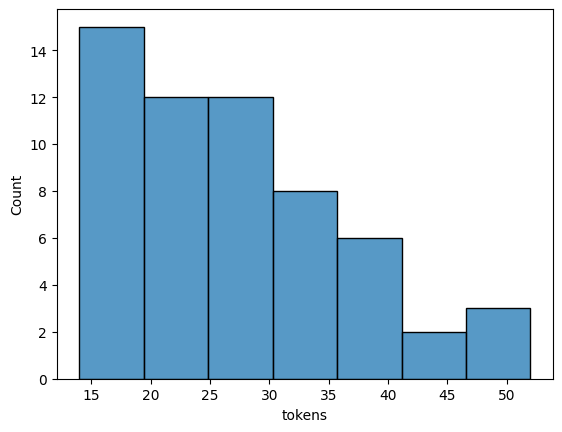

In [11]:
def num_tokens_from_string(string: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.encoding_for_model("gpt-4")
    num_tokens = len(encoding.encode(string))
    return num_tokens


atomic_facts = graph.query("MATCH (a:AtomicFact) RETURN a.text AS text")
df = pd.DataFrame.from_records(
    [{"tokens": num_tokens_from_string(el["text"])} for el in atomic_facts]
)

sns.histplot(df["tokens"])

Atomic facts are relatively short, with the longest being only about 50 tokens. Let’s examine a couple to get a better idea.

In [12]:
graph.query("""MATCH (a:AtomicFact) 
RETURN a.text AS text
ORDER BY size(text) ASC LIMIT 3
UNION ALL
MATCH (a:AtomicFact) 
RETURN a.text AS text
ORDER BY size(text) DESC LIMIT 3""")

[{'text': 'In 1430, Joan of Arc was captured by Burgundian forces.'},
 {'text': 'In 1920, Joan of Arc was canonized by Pope Benedict XV.'},
 {'text': 'Joan of Arc was captured by Burgundian troops on 23 May.'},
 {'text': "Joan of Arc was put on trial by Bishop Pierre Cauchon on accusations of heresy, including blaspheming by wearing men's clothes, acting upon visions that were demonic, and refusing to submit her words and deeds to the judgment of the church."},
 {'text': 'Joan of Arc encouraged the French to pursue the English during the Loire Campaign, leading to a victory at Patay and allowing the French army to advance on Reims, where Charles VII was crowned king with Joan at his side.'},
 {'text': "The film was directed by Carl Theodor Dreyer and stars Renée Jeanne Falconetti as Joan, and it is widely regarded as a landmark of cinema, especially for its production, Dreyer's direction, and Falconetti's performance."}]

Let’s also examine the most frequent keywords.

<Axes: xlabel='key', ylabel='connections'>

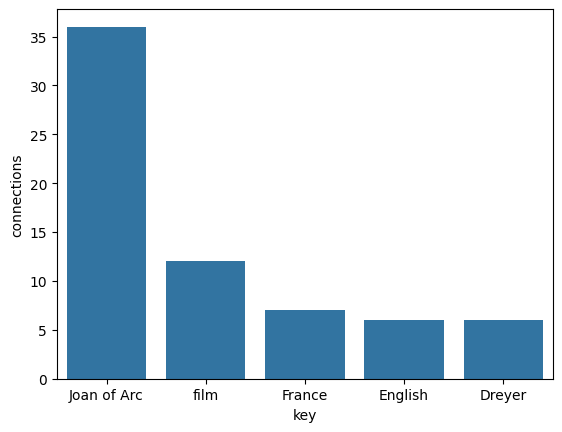

In [13]:
data = graph.query("""
MATCH (a:KeyElement) 
RETURN a.id AS key, 
       count{(a)<-[:HAS_KEY_ELEMENT]-()} AS connections
ORDER BY connections DESC LIMIT 5""")
df = pd.DataFrame.from_records(data)
sns.barplot(df, x='key', y='connections')

Unsurprisingly, Joan of Arc is the most mentioned keyword or element. Following are broad keywords like film, English, and France. I suspect that if we parsed many documents, broad keywords would end up having a lot of connections, which might lead to some downstream problems that aren’t dealt with in the original implementation. Another minor problem is the non-determinism of the extraction, as the results will be slight different on every run.

Additionally, the authors employ key element normalization as described in Lu et al. (2023), specifically using frequency filtering, rule, semantic, and association aggregation. In this implementation, we skipped this step.